**Chapter 7 - Ensemble Learning and Random Forests**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [18]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [19]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

define the default font sizes to make the figures prettier:

In [20]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Create the `images/ensembles` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [21]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

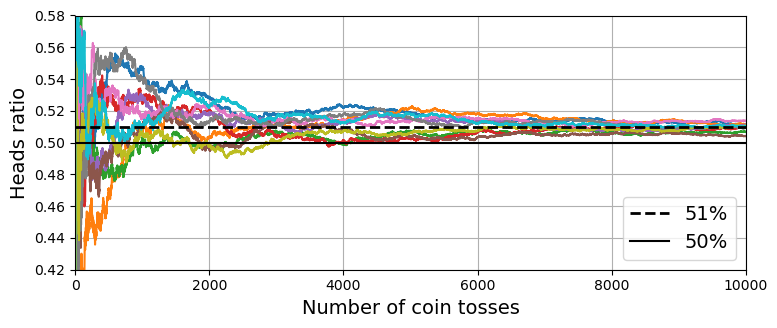

In [22]:
# extra code – this cell generates and saves Figure 7–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers_plot")
plt.show()

Let's build a voting classifier:

In [23]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(random_state=42)),
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [24]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [25]:
voting_clf.predict(X_test[:1])

array([1])

In [26]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [27]:
voting_clf.score(X_test, y_test)

0.912

Now let's use soft voting:

In [28]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

## Bagging and Pasting in Scikit-Learn

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clr = BaggingClassifier(
    DecisionTreeClassifier(),
    random_state=42,
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
)
bag_clr.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

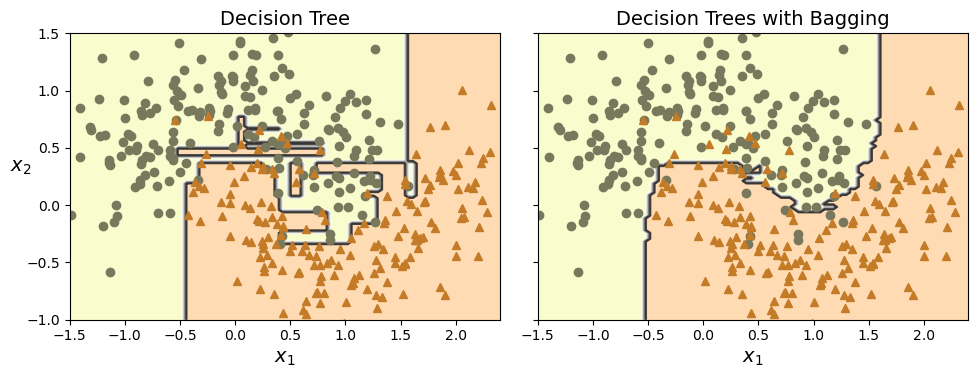

In [31]:
# extra code – this cell generates and saves Figure 7–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clr, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation

In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [33]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [34]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [35]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# Random Forests

In [36]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42,    
)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees:

In [37]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [38]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

## Feature Importance

In [39]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


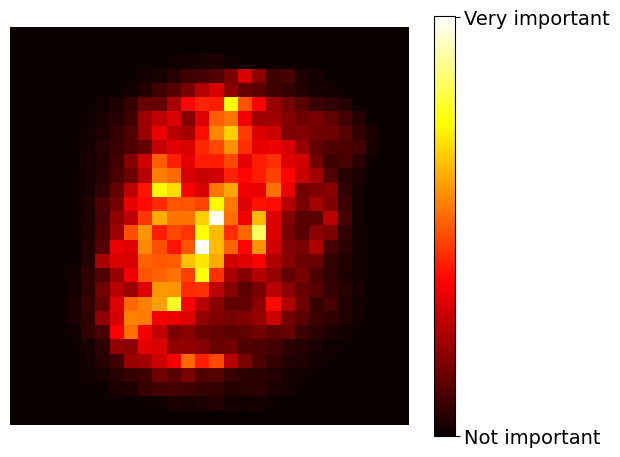

In [40]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting

## AdaBoost

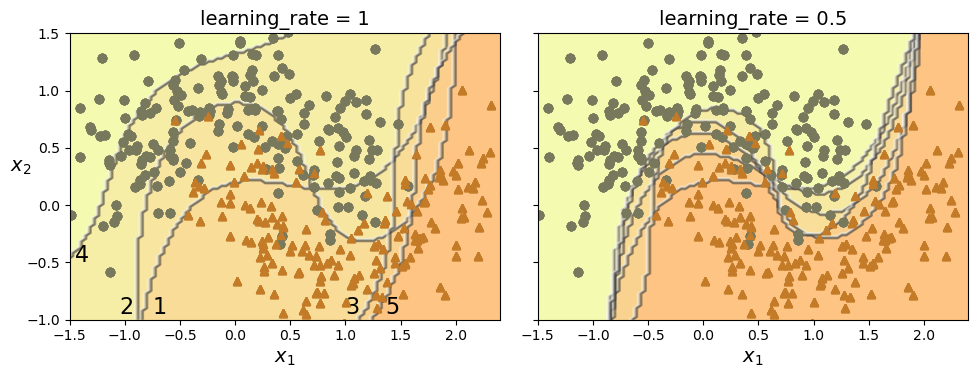

In [41]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [42]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

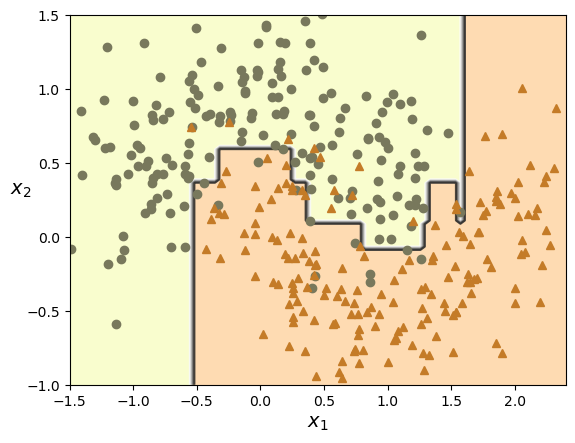

In [43]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting

Create a simple quadratic dataset and fit a `DecisionTreeRegressor` to it:

In [44]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Train another decision tree regressor on the residual errors made by the previous predictor:

In [45]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [46]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [47]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

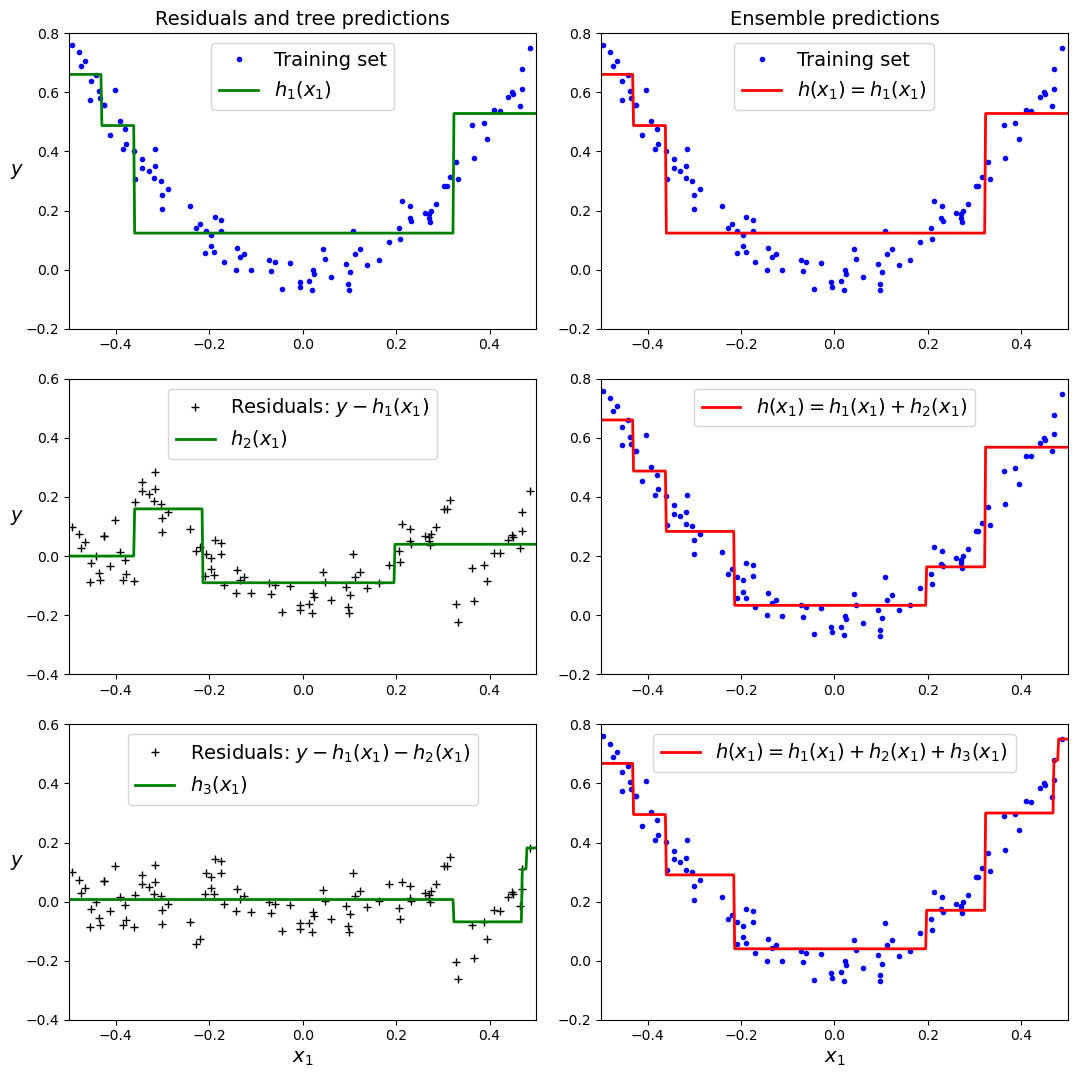

In [48]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

Try a gradient boosting regressor:

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [50]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [51]:
gbrt_best.n_estimators_

92

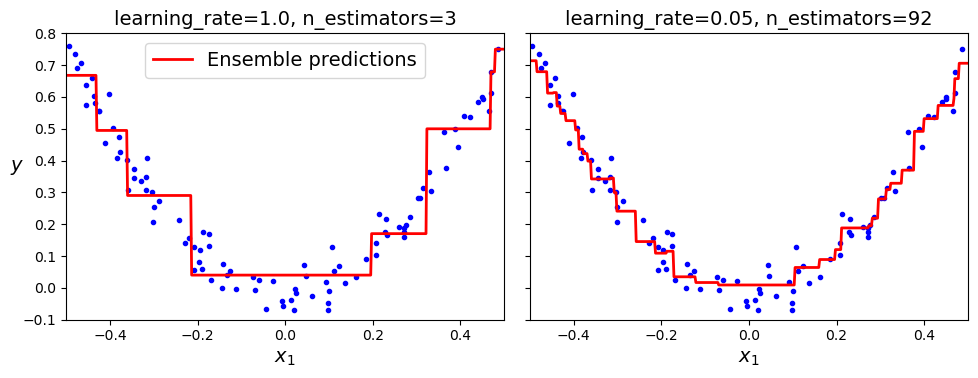

In [52]:
# extra code – this cell generates and saves Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

In [53]:
# extra code – at least not in this chapter, it's presented in chapter 2

import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [54]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [55]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64